# Using the low-level numpy interface (no xarray involved)

In [1]:
%matplotlib inline
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xesmf as xe

## Generate grid and fake data

### Convenience function for grid generation

In [2]:
def grid_1d(start_b, end_b, step):
    bounds = np.arange(start_b, end_b+step, step)
    centers = (bounds[:-1] + bounds[1:])/2

    return centers, bounds

In [3]:
def grid_2d(lon0_b, lon1_b, n_lon,
            lat0_b, lat1_b, n_lat):
    
    lon_1d, lon_b_1d = grid_1d(lon0_b, lon1_b, n_lon)
    lat_1d, lat_b_1d = grid_1d(lat0_b, lat1_b, n_lat)
    
    lon, lat = np.meshgrid(lon_1d, lat_1d)
    lon_b, lat_b = np.meshgrid(lon_b_1d, lat_b_1d)
    
    return {'lon':lon, 'lat':lat, 'lon_b':lon_b, 'lat_b':lat_b}

### Generate input grid

In [4]:
ingrid = grid_2d(-120, 120, 4, -60, 60, 4)

### Create fake input data

In [5]:
Nlat, Nlon = ingrid['lon'].shape
wave = lambda n,k: np.sin(np.linspace(0, k*np.pi, n))

indata = np.outer(wave(Nlat,2), wave(Nlon,3))+2

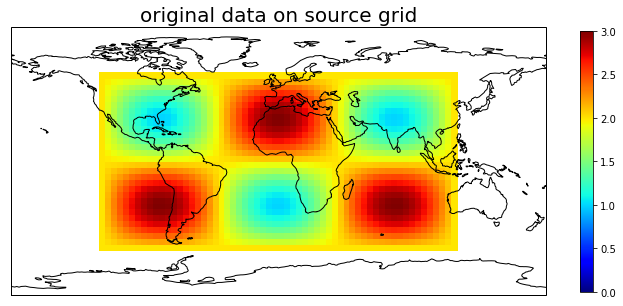

In [6]:
fig = plt.figure(figsize=[12,8])
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.pcolormesh(ingrid['lon_b'], ingrid['lat_b'], indata,
                   vmin=0, vmax=3, cmap='jet')
ax.coastlines()
ax.set_global()
fig.colorbar(im, ax=ax, orientation='vertical',shrink=0.6)
ax.set_title('original data on source grid', fontsize=20)

### Generate output grids

In [7]:
outgrid_coarse = grid_2d(-180, 180, 10, -90, 90, 10)
outgrid_fine= grid_2d(-180, 180, 2, -90, 90, 2)

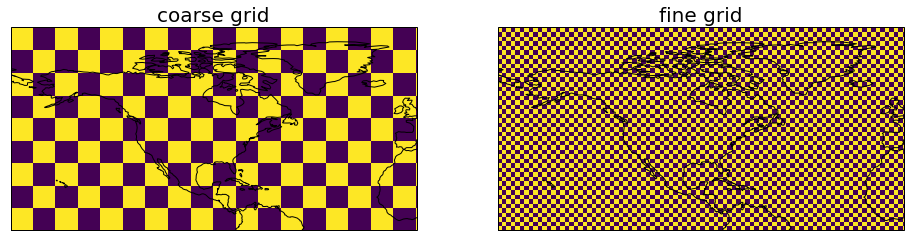

In [8]:
def checkerboard(w, h) :
    ''' 
    Make a checkerboard to show the grid. Assume even-numbered grid points.
    '''
    re = np.array( w*[0,1] )              # even-numbered rows
    ro = np.array( w*[1,0] )             # odd-numbered rows
    return np.row_stack(h*(re, ro))

def plot_grid(ax, grid):
    Nlat, Nlon = grid['lon'].shape
    ax.pcolormesh(grid['lon_b'], grid['lat_b'], checkerboard(Nlon//2, Nlat//2))
    ax.coastlines()
    ax.set_xlim([-180,0]);ax.set_ylim([0,90]);

fig, axes = plt.subplots(1,2,figsize=[16,8],subplot_kw=dict(projection=ccrs.PlateCarree()))
plot_grid(axes[0],outgrid_coarse);axes[0].set_title('coarse grid', fontsize=20)
plot_grid(axes[1],outgrid_fine);axes[1].set_title('fine grid', fontsize=20)

## Calling low-level wrapper in xESMF

### Create ESMF grid instance

In [9]:
Egrid_in = xe.ESMF_grid(ingrid['lon'], ingrid['lat'], 
                        lon_b=ingrid['lon_b'], lat_b = ingrid['lat_b'])

Passing cell corners. Conservative regridding is available.


In [10]:
help(xe.ESMF_grid)

Help on function ESMF_grid in module xesmf.lowlevel:

ESMF_grid(lon, lat, lon_b=None, lat_b=None, verbose=True)
    Create an ESMF grid object, which can be an input for ESMF_regrid()
    
    Parameters
    ----------
    lon, lat : numpy array of shape (Nlat, Nlon)
        Longitute/Latitude of cell centers
    
    lon_b, lat_b : optional, numpy array of shape (Nlat+1, Nlon+1)
        Longitute/Latitude of cell boundaries (corners)
        Corner information is needed by conservative regridding.
    
    verbose: bool, optional
        Print diagnostics for debugging.
        
    
    Returns
    -------   
    grid: ESMF Grid class



This is an "ESMF Grid Class", defined in ESMPy 

In [11]:
type(Egrid_in)

ESMF.api.grid.Grid

In [12]:
Egrid_out_coarse = xe.ESMF_grid(outgrid_coarse['lon'], outgrid_coarse['lat'], 
                               lon_b=outgrid_coarse['lon_b'], lat_b = outgrid_coarse['lat_b'])

Egrid_out_fine = xe.ESMF_grid(outgrid_fine['lon'], outgrid_fine['lat'], 
                             lon_b=outgrid_fine['lon_b'], lat_b = outgrid_fine['lat_b'])

Passing cell corners. Conservative regridding is available.
Passing cell corners. Conservative regridding is available.


### Perform regridding 

In [13]:
outdata_coarse_bi = xe.ESMF_regrid(Egrid_in, Egrid_out_coarse, indata, method='bilinear')
outdata_fine_bi = xe.ESMF_regrid(Egrid_in, Egrid_out_fine, indata, method='bilinear')

outdata_coarse_con = xe.ESMF_regrid(Egrid_in, Egrid_out_coarse, indata, method='conservative')
outdata_fine_con = xe.ESMF_regrid(Egrid_in, Egrid_out_fine, indata, method='conservative')

### Check results

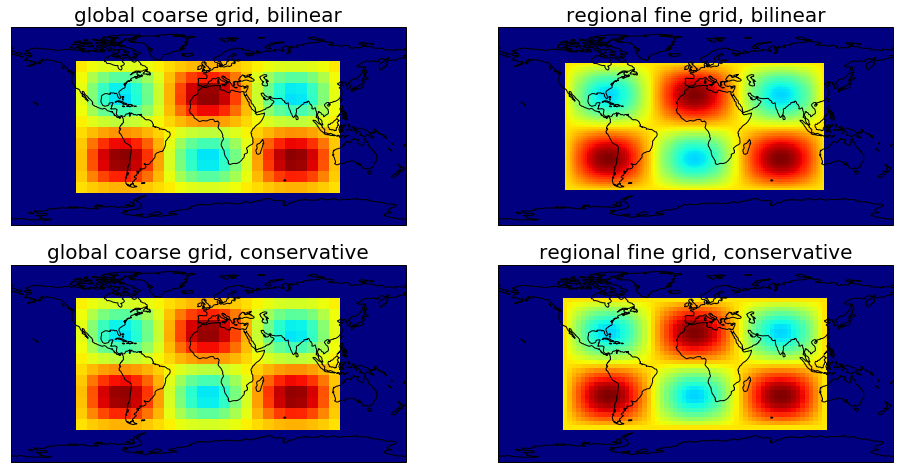

In [14]:
def plot_datafield(ax, grid, data):
    ax.pcolormesh(grid['lon_b'], grid['lat_b'], data,
                  vmin=0, vmax=3, cmap='jet')
    ax.coastlines()
    ax.set_global()

fig, axes = plt.subplots(2,2,figsize=[16,8],subplot_kw=dict(projection=ccrs.PlateCarree()))

plot_datafield(axes[0,0], outgrid_coarse, outdata_coarse_bi)
axes[0,0].set_title('global coarse grid, bilinear', fontsize=20)

plot_datafield(axes[0,1], outgrid_fine, outdata_fine_bi)
axes[0,1].set_title('regional fine grid, bilinear', fontsize=20)

plot_datafield(axes[1,0], outgrid_coarse, outdata_coarse_con)
axes[1,0].set_title('global coarse grid, conservative', fontsize=20)

plot_datafield(axes[1,1], outgrid_fine, outdata_fine_con)
axes[1,1].set_title('regional fine grid, conservative', fontsize=20)